In [75]:
# 1 - EXPLORAÇÃO DA BASE DE DADOS
import glob
import cv2
import matplotlib.pyplot as plt

# Método que exibe imagens das classes que serão apresentadas na próxima célula
def show_multiple_imgs_plt(images_array, titles_array, fig_size=(15, 15), show_axis=False):
    # Determinar o número de linhas e colunas
    num_rows = len(images_array)
    num_cols = len(images_array[0]) if num_rows > 0 else 0

    # Criar a figura e os eixos
    _, axis = plt.subplots(num_rows, num_cols, figsize=fig_size)

    # Garantir que 'axis' seja sempre uma lista de listas
    if num_rows == 1:
        axis = [axis]
    if num_cols == 1:
        axis = [[ax] for ax in axis]

    # Exibir as imagens
    for i in range(num_rows):
        for j in range(num_cols):
            ax = axis[i][j]
            ax.imshow(cv2.cvtColor(images_array[i][j], cv2.COLOR_BGR2RGB))
            ax.set_anchor('NW')
            ax.set_title(titles_array[i][j], fontdict={'fontsize': 15, 'fontweight': 'medium'}, pad=10)
            if not show_axis:
                ax.axis('off')

    plt.tight_layout()
    plt.show()

Número de imagens saudáveis: 100
Número de imagens doentes: 100


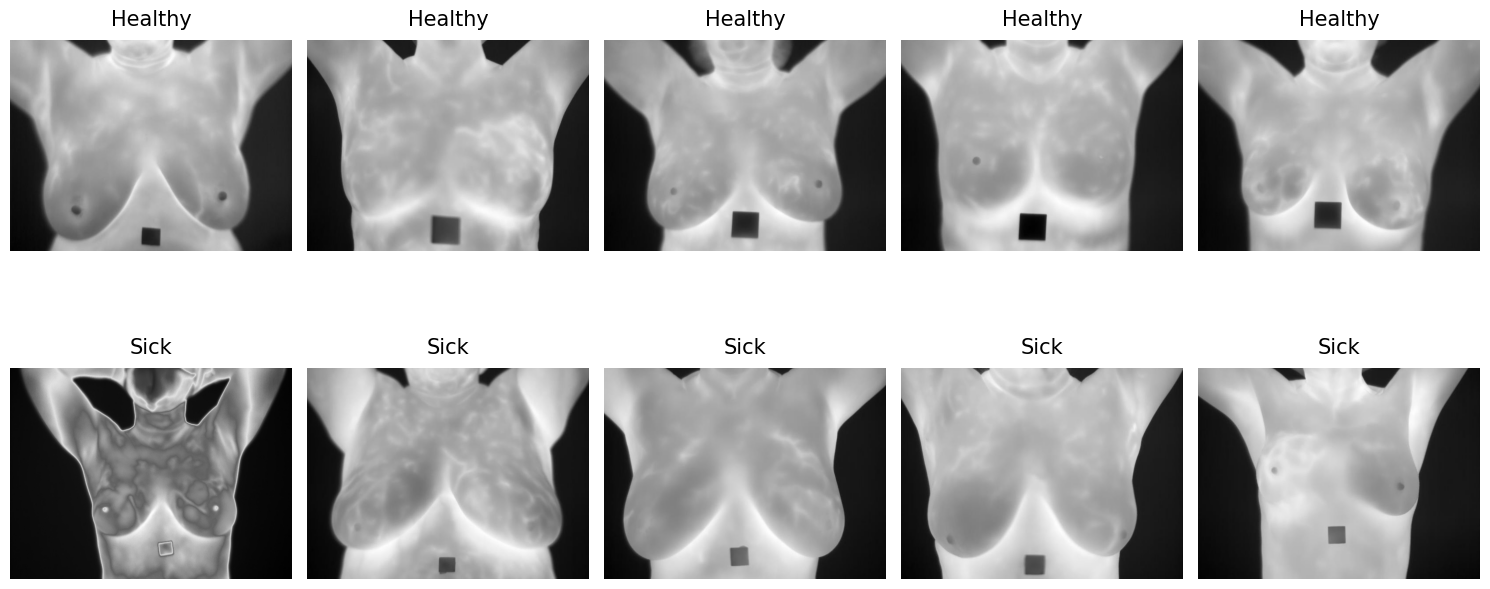

In [76]:
# 1 - EXPLORAÇÃO DA BASE DE DADOS

# A base de dados utilizada é a DMR-IR, que contém imagens termográficas das mamas coletadas pelo
# Laboratório Visual para Pesquisa em Mastologia da Universidade Federal Fluminense (UFF)
# em Niterói, Brasil. As imagens foram capturadas usando uma câmera térmica FLIR SC620 e possuem
# resolução de 480 x 640 pixels. A base de dados inclui três classes de imagens: healthy (saudáveis),
# sick (doentes), e unknown (desconhecidas) de pacientes numerados de 1 a 287. Para este projeto,
# foram usadas apenas imagens das classes "healthy" e "sick".

# Relevância para o Treinamento do Modelo: A classificação de interesse neste projeto é entre
# "saudável" (healthy) e "doente" (sick). A classe "unknown" contém imagens de casos que não
# foram diagnosticados ou não possuem uma classificação clara, o que poderia introduzir ruído
# e incerteza nos dados de treinamento, dificultando a aprendizagem do modelo e a interpretação
# dos resultados.

# Optou-se por baixar as imagens em escala de cinza devido à natureza da análise termográfica,
# onde a variação de temperatura é o foco principal. As imagens em escala de cinza facilitam a
# interpretação dos dados térmicos, removendo a complexidade que pode ser introduzida por
# imagens coloridas.

# Definindo o caminho da base de dados
# Ao baixar as imagens do site http://visual.ic.uff.br/dmi/, as separei em duas pastas diferentes
# uma para as classificadas como healthy.
from google.colab import drive
drive.mount('/content/drive')
ROOT_PATH = "/content/drive/MyDrive/Unifesp/IA/termography/dataset/"
healthy_data_path  = ROOT_PATH + "original/healthy/"
sick_data_path     = ROOT_PATH + "original/sick/"

# Carregando lista dos caminhos da imagens de cada classe
healthy_list = glob.glob(healthy_data_path + '*.jpg')
sick_list    = glob.glob(sick_data_path + '*.jpg')

# Analisando a base de dados
print(f"Número de imagens saudáveis: {len(healthy_list)}")
print(f"Número de imagens doentes: {len(sick_list)}")


# Exibindo algumas imagens das classes "healthy" e "sick"
n_imgs = 5

imgs_healthy   = [cv2.imread(x) for x in healthy_list[:n_imgs]]
labels_healthy = ['Healthy' for x in healthy_list[:n_imgs]]

imgs_sick   = [cv2.imread(x) for x in sick_list[:n_imgs]]
labels_sick = ['Sick' for x in sick_list[:n_imgs]]

imgs   = imgs_healthy + imgs_sick
labels = labels_healthy + labels_sick

show_multiple_imgs_plt([imgs[:5], imgs[5:]], [labels[:5], labels[5:]], fig_size = (15,8), show_axis=False)

In [77]:
# 2 - LIMPEZA DOS DADOS
# Conforme mencionadoa anteriormente, as imagens tiveram que ser baixadas uma a uma, logo
# parte do trabalho foi selecionar no site da base de dados as imagens que fossem frontais
# e com classificação healthy ou sick, já que ununknown não é interessante tanto para o treinamento
# quanto validação.

# Função para limpar e redimensionar imagens que não estejam no tamanho informado pela base dados ou corrompidas
def preprocess_image(img, size=(640, 480)):
    # Verificar se a imagem foi carregada corretamente
    if img is None:
        return None
    # Redimensionar a imagem
    img_resized = cv2.resize(img, size)
    return img_resized

# Lendo as imagens em escala de cinza, já que as cores não são pertinentes para o treinamento da rede, uma vez que
# a termografia pode ser analisada em apenas uma camada da imagem sendo onde está mais claro são regiões mais quentes
# e mais escuro regiões mais frias.
healthy_imgs = [preprocess_image(cv2.imread(x, cv2.IMREAD_GRAYSCALE)) for x in healthy_list]
sick_imgs = [preprocess_image(cv2.imread(x, cv2.IMREAD_GRAYSCALE)) for x in sick_list]

# Removendo imagens que não foram carregadas corretamente
healthy_imgs = [img for img in healthy_imgs if img is not None]
sick_imgs = [img for img in sick_imgs if img is not None]

print(f"Imagens saudáveis após limpeza: {len(healthy_imgs)}")
print(f"Imagens doentes após limpeza: {len(sick_imgs)}")

Imagens saudáveis após limpeza: 100
Imagens doentes após limpeza: 100


In [78]:
# Função que aplica crop apenas na região de interesse
def apply_crop(img):

    # Definir as coordenadas do retângulo para a região da axila para baixo
    height, width = img.shape
    x_inicial = 0
    y_inicial = int(height // 2.5)  # Aproximadamente 1/3 da altura
    x_final = width
    y_final = height

    # Extrair a região de interesse (ROI)
    return img[y_inicial:y_final, x_inicial:x_final]

In [79]:
import numpy as np
def normalize_image(img: np.ndarray) -> np.ndarray:
    """
   Normaliza os valores de pixel de uma imagem para o intervalo [0, 255].

    Esta função usa `cv2.normalize` do OpenCV para normalizar os valores de pixel da imagem de entrada.
    Os valores de pixel são dimensionados para abranger toda a faixa de 0 a 255. Isso pode melhorar o contraste
    da imagem e é útil para etapas de pré-processamento em tarefas de processamento de imagem.

    Argumentos:
        img (np.ndarray): A imagem de entrada a ser normalizada.

    Retorna:
        np.ndarray: A imagem normalizada com valores de pixel no intervalo [0, 255].
    """
    normalized_img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    return np.uint8(normalized_img)

# Função para aplicar o filtro de contorno
def apply_filter(image):
    laplacian = cv2.Laplacian(image, cv2.CV_64F, ksize=21, delta=11)
    return normalize_image(laplacian)

In [80]:
# Haverão diferentes pré-processametos testados para cada modelo:
# sem pré-processamento, crop, laplacian filter, além disso
# cada um desses serão submetidos a um data augmentation chamado mixup.
# Então, cada modelo será submetido a treinamento e teste com 6 diferentes condições:
# sem pré-processmento
# crop
# laplacian filter
# mixup
# crop e mixup
# laplacian filter e mixuo

import os

healthy_crop_path  = ROOT_PATH + "crop/healthy/"
sick_crop_path     = ROOT_PATH + "crop/sick/"

healthy_filter_path  = ROOT_PATH + "laplacian/healthy/"
sick_filter_path     = ROOT_PATH + "laplacian/sick/"

# Enum que identifica o pré-processamento
from enum import Enum
class PreProcessImage(Enum):
    ORIGINAL = 0
    CROP = 1
    LAPLACIAN_FILTER = 2

# Obtém nome das imagens originais do dataset
healthy_image_names = [os.path.basename(img_path) for img_path in healthy_list]
sick_image_names = [os.path.basename(img_path) for img_path in sick_list]

# verifica se a quantidade de imagens na pasta é igual ao esperado
def __check_dir_images(dir_path, expected_num_imgs):
    if len(os.listdir(dir_path)) < expected_num_imgs:
        return False
    return True

# escreve imagem
def __write_image(img_path, img):
    cv2.imwrite(img_path, img)

# aplica pré-processamento a depender do escolhido no Enum
def __apply_pre_processing(pre_process_type: PreProcessImage, img):
    if pre_process_type == PreProcessImage.CROP:
        return apply_crop(img)

    elif pre_process_type == PreProcessImage.LAPLACIAN_FILTER:
        return apply_filter(img)

# Aplica filtro de pré-processamento e escreve na pasta correta, caso ainda não tenha feito isso
def handle_pre_process_imgs(dir_path, expected_num_imgs, img_names, image_list, pre_process_type: PreProcessImage):
    if not __check_dir_images(dir_path, expected_num_imgs):
        for i in range(expected_num_imgs):
            img_pre_processed = __apply_pre_processing(pre_process_type, image_list[i])
            __write_image(dir_path + img_names[i], img_pre_processed)


handle_pre_process_imgs(dir_path=healthy_crop_path,
                        expected_num_imgs=len(healthy_imgs),
                        img_names=healthy_image_names,
                        image_list=healthy_imgs,
                        pre_process_type=PreProcessImage.CROP)

handle_pre_process_imgs(dir_path=sick_crop_path,
                        expected_num_imgs=len(sick_imgs),
                        img_names=sick_image_names,
                        image_list=sick_imgs,
                        pre_process_type=PreProcessImage.CROP)

handle_pre_process_imgs(dir_path=healthy_filter_path,
                        expected_num_imgs=len(healthy_imgs),
                        img_names=healthy_image_names,
                        image_list=healthy_imgs,
                        pre_process_type=PreProcessImage.LAPLACIAN_FILTER)

handle_pre_process_imgs(dir_path=sick_filter_path,
                        expected_num_imgs=len(sick_imgs),
                        img_names=sick_image_names,
                        image_list=sick_imgs,
                        pre_process_type=PreProcessImage.LAPLACIAN_FILTER)

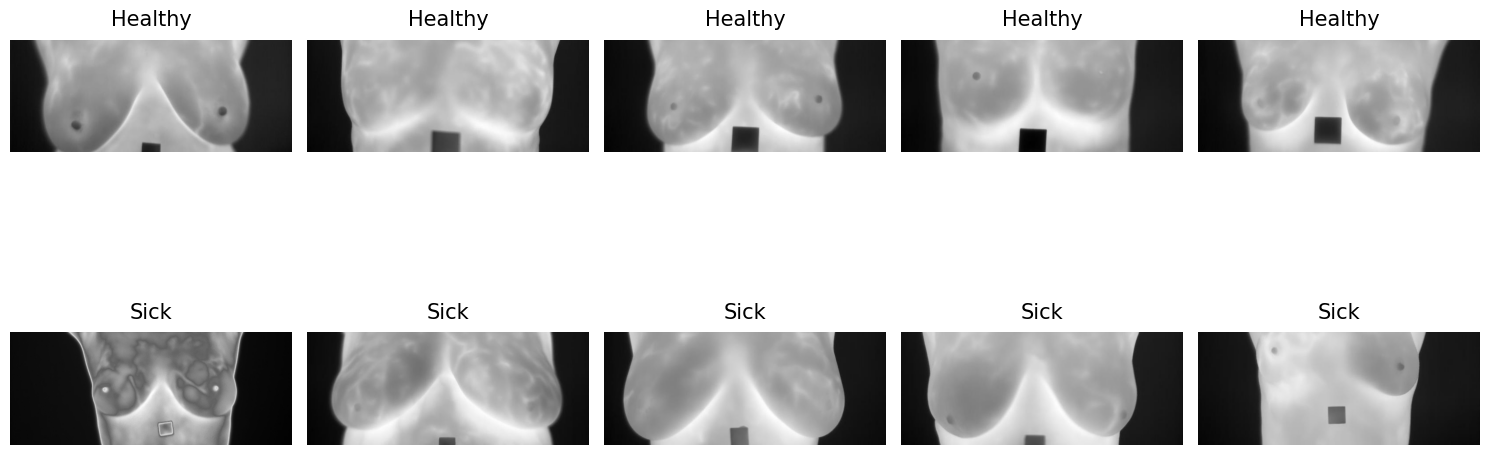

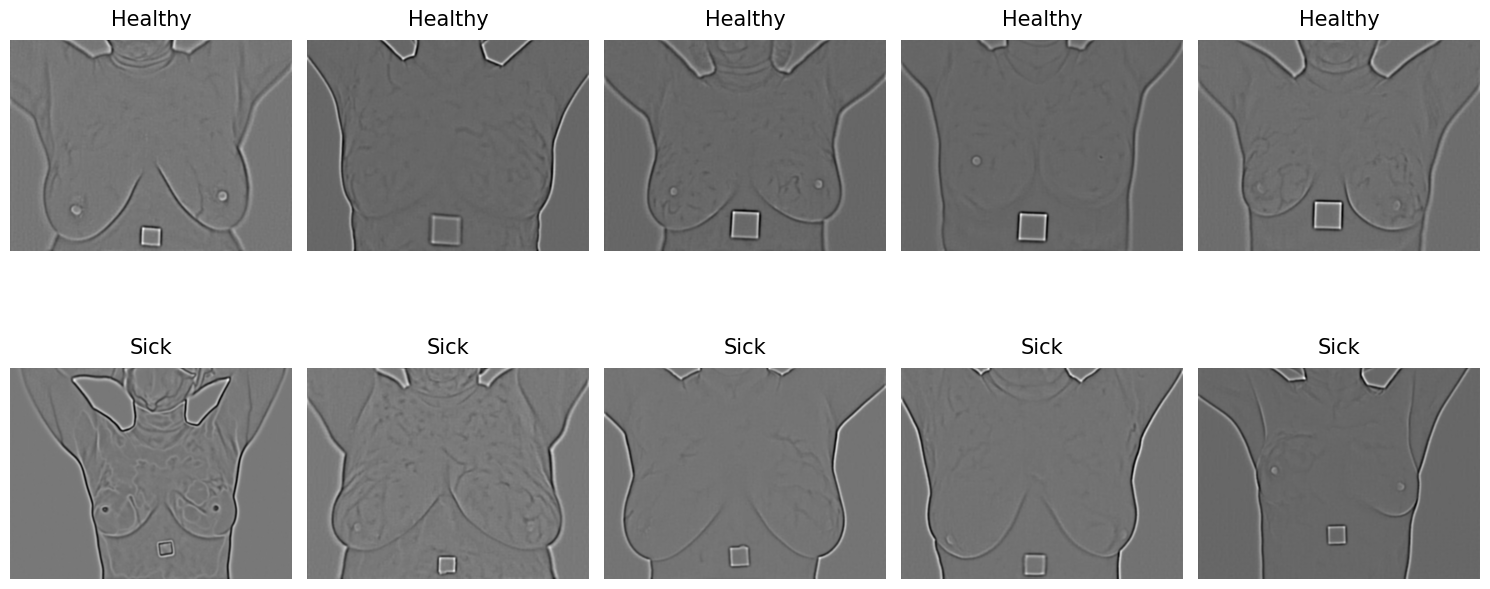

In [81]:
healthy_crop_list = glob.glob(healthy_crop_path + '*.jpg')
sick_crop_list    = glob.glob(sick_crop_path + '*.jpg')
imgs_crop_healthy   = [cv2.imread(x) for x in healthy_crop_list[:n_imgs]]
labels_crop_healthy = ['Healthy' for x in healthy_crop_list[:n_imgs]]
imgs_crop_sick   = [cv2.imread(x) for x in sick_crop_list[:n_imgs]]
labels_crop_sick = ['Sick' for x in sick_crop_list[:n_imgs]]
imgs_crop   = imgs_crop_healthy + imgs_crop_sick
labels_crop = labels_crop_healthy + labels_crop_sick
show_multiple_imgs_plt([imgs_crop[:5], imgs_crop[5:]], [labels_crop[:5], labels_crop[5:]], fig_size = (15,8), show_axis=False)


healthy_filter_list = glob.glob(healthy_filter_path + '*.jpg')
sick_filter_list    = glob.glob(sick_filter_path + '*.jpg')
imgs_filter_healthy   = [cv2.imread(x) for x in healthy_filter_list[:n_imgs]]
labels_filter_healthy = ['Healthy' for x in healthy_filter_list[:n_imgs]]
imgs_filter_sick   = [cv2.imread(x) for x in sick_filter_list[:n_imgs]]
labels_filter_sick = ['Sick' for x in sick_filter_list[:n_imgs]]
imgs_filter   = imgs_filter_healthy + imgs_filter_sick
labels_filter = labels_filter_healthy + labels_filter_sick
show_multiple_imgs_plt([imgs_filter[:5], imgs_filter[5:]], [labels_filter[:5], labels_filter[5:]], fig_size = (15,8), show_axis=False)



In [82]:
# Imports:
from __future__ import print_function, division

import torch
import torch.backends.cudnn as cudnn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import time
import os
from PIL import Image


In [83]:
# 3 - FORMATAÇÃO DOS DADOS PARA UTILIZAÇÃO PELO ALGORITMO DE APRENDIZAGEM

# Limpar o cache da CUDA
torch.cuda.empty_cache()
cudnn.benchmark = True

class CustomImageDataset(Dataset):
    """
    A classe CustomImageDataset é uma implementação personalizada do PyTorch Dataset para carregar e
    transformar imagens a partir da lista de imagens fornecida. Cada imagem é carregada a partir do
    disco e convertida para o formato RGB, e a transformação é aplicada se fornecida.
    """
    def __init__(self, images_list, root_path, transform=None):
        self.images_list = images_list
        self.transform = transform
        self.root_path = root_path

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # constrói o caminho completo para a imagem a ser carregada
        img_name = os.path.join(self.root_path, self.images_list[idx]['subfolder'], self.images_list[idx]['img'])
        # converte a imagem para o formato RGB
        image = Image.open(img_name).convert('RGB')
        # obtém label da imagem a partir da lista de imagens
        label = self.images_list[idx]['label']

        # aplica a transformação, se fornecida
        if self.transform:
            image = self.transform(image)

        return image, label

# Função para aplicar o MixUp
def mixup_data(x, y, alpha=1.0):
    '''Retorna dados mixados, pares de rótulos e o valor de lambda'''
    if alpha > 0:
        # cria combinações dinâmicas e variadas de imagens e rótulos
        lam = np.random.beta(alpha, alpha)
    else:
        # não faz mixup
        lam = 1

    # Eembaralha os índices do batch
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    # combina as imagens de acordo com lambda
    mixed_x = lam * x + (1 - lam) * x[index, :]
    # rótulos originais e embaralhados
    y_a, y_b = y, y[index]
    # retorna os dados mixados e os rótulos
    return mixed_x, y_a, y_b, lam

def data_preprocessing(images_list, root_path, use_mixup, batch_size=32, workers=2, device='cuda:0', alpha=1.0):
    """
    Organiza e prepara os dados de imagem para treinamento e teste, configurando transformações,
    criando datasets e dataloaders, e configurando o dispositivo para processamento.
    """

    # define o tamanho padrão para ResNet50, Efficentnet e Vgg19 o size padrão é 224
    DEFAULT_RESIZE = 224
    # valores para normalização, são os melhores valores para Resnet50, Efficentnet e Vgg19
    DEFAULT_NORMALIZE_VALUES = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Compõe as transformações de dados
    train_data_transforms = transforms.Compose([
        transforms.Resize((DEFAULT_RESIZE, DEFAULT_RESIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(*DEFAULT_NORMALIZE_VALUES)
    ])

    # Note que para test RandomHorizontalFlip não pode ser aplicado
    test_data_transforms = transforms.Compose([
        transforms.Resize((DEFAULT_RESIZE, DEFAULT_RESIZE)),
        transforms.ToTensor(),
        transforms.Normalize(*DEFAULT_NORMALIZE_VALUES)
    ])

    def collate_fn(batch):
        # desempacota as imagens e os rótulos
        images, labels = zip(*batch)
        # empilha as imagens em um único tensor
        images = torch.stack(images)
        # converte os rótulos em tensor
        labels = torch.tensor(labels)
        # aplica o Mixup
        mixed_x, y_a, y_b, lam = mixup_data(images, labels, alpha)
        return mixed_x, y_a, y_b, lam

    # cria os datasets
    train_dataset = CustomImageDataset(images_list[0], root_path, transform=train_data_transforms)
    test_dataset = CustomImageDataset(images_list[1], root_path, transform=test_data_transforms)

    # cria os dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers, collate_fn=collate_fn) if use_mixup else DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

    # tamanhos do dataset e nomes das classes
    dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}
    class_names = list(set(img['label'] for img in images_list[0] + images_list[1]))

    print(f"classnames: {class_names}")

    # configura device
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    return {'train': train_loader, 'test': test_loader}, dataset_sizes, class_names, device

In [84]:
# 4 - SEPARAR A BASE EM TREINO E TESTE
# Neste trecho, será utilizada a técnica de validação cruzada 10-fold para avaliar o modelo.
# Com um total de 200 itens, o KFold dividirá os dados em 10 partes iguais,
# cada uma contendo 20 itens. Em cada iteração da validação cruzada,
# uma das partes será usada como conjunto de validação, enquanto as outras 9 partes serão usadas para o treinamento.
# Isso permite que o modelo seja avaliado de forma robusta, já que cada parte dos dados
# será utilizada tanto para treinar quanto para validar o modelo em diferentes iterações.

import os
import numpy as np
import random
from sklearn.model_selection import KFold
random.seed(1234)

class NetModel(Enum):
    RESNET50 = 0
    EFFICENTNET = 1
    VGG19 = 2

class PreProcessData:
    """
    Classe para pré-processar os dados e gerenciar a validação cruzada
    """
    def __init__(self, dataset_path, pre_process_type, pre_processing, use_mixup, net_model):
        self.dataset_path = dataset_path  # Caminho para o dataset
        self.pre_process_type = pre_process_type  # Tipo de pré-processamento aplicado
        self.pre_processing = pre_processing  # Nome do pré-processamento utilizado
        self.use_mixup = use_mixup  # Flag para usar MixUp
        self.net_model = net_model  # Para salvar modelo de rede neural treinado
        self.accuracies = []  # Lista para armazenar acurácias
        self.model_ft = None  # Modelo treinado
        self.kfold_splits = []  # Lista para armazenar as divisões do KFold
        self.images_list = []  # Lista de imagens e suas informações
        self.mean_accuracies = None  # Acurácia média (a ser calculada)
        self.std_accuracy = None  # Desvio padrão das acurácias (a ser calculado)
        self.feature_layer_name = None  # Nome da camada de recursos (dependente do modelo)
        self.name = None  # Nome do modelo (para referência)
        self.confusion_matrix = None # Matriz de confusao 
        self.train_losses = None # Perdas do treinamento durante as épocas
        self.train_accuracies = None # Acurácias durante as épocas do treinamento

        self.__set_subfolders_dictionary()  # Prepara o dicionário de subpastas
        self.__set_based_on_model_type()  # Configura informações baseadas no modelo escolhido

    # soma as acurácias durante as épocas de cada fold
    def sum_train_accuracies(self, train_accuracies):
        if self.train_accuracies is None:
            self.train_accuracies = train_accuracies
        else:
            self.train_accuracies = np.add(self.train_accuracies, train_accuracies)
            
    # soma as perdas durante as épocas de cada fold
    def sum_train_losses(self, train_losses):
        if self.train_losses is None:
            self.train_losses = train_losses
        else:
            self.train_losses = np.add(self.train_losses, train_losses)

    # obtém a média das acurácias dos folds
    def mean_train_accuracies(self, kfold_splits):
        self.train_accuracies = self.train_accuracies / kfold_splits
    
    # obtém a média das perdas dos folds
    def mean_train_losses(self, kfold_splits):
        self.train_losses = self.train_losses / kfold_splits

    # calcula as acurácias
    def set_accuracies(self, accuracies):
        self.accuracies = accuracies
        self.mean_accuracy = np.mean(accuracies)
        self.std_accuracy = np.std(accuracies)

    # salva modelo para ser usado pelo cam
    def set_model(self, model_ft):
        self.model_ft = model_ft

    # soma as matrizes de confusão de cada fold
    def sum_confusion_matrix(self, cm):
        if self.confusion_matrix is None:
            self.confusion_matrix = cm
        else: 
            self.confusion_matrix += cm

    def __set_based_on_model_type(self):
        if self.net_model == NetModel.RESNET50:
            self.feature_layer_name = 'layer4'
            self.name = "Resnet"
        elif self.net_model == NetModel.EFFICENTNET:
            self.feature_layer_name = 'features'
            self.name = "Efficentnet"
        elif self.net_model == NetModel.VGG19:
            self.feature_layer_name = 'features'
            self.name = "Vgg19"
    

    def __set_subfolders_dictionary(self):
        """
        Cria uma lista de dicionários contendo informações sobre as imagens em cada subpasta.
        Cada dicionário contém o caminho da imagem, o nome da subpasta (classe) e o rótulo numérico da classe.
        """
        labels_dict = {}
        current_label = 0

        # itera sobre todas as subpastas no caminho raiz
        for subfolder in os.listdir(self.dataset_path):
            if os.path.isdir(os.path.join(self.dataset_path, subfolder)):
                # obtém a lista de imagens na subpasta
                images = [image for image in os.listdir(os.path.join(self.dataset_path, subfolder)) if image.endswith(('.jpg'))]
                for img in images:
                    # gerando um número único para cada nome da pasta de imagens
                    if subfolder in labels_dict:
                        label = labels_dict[subfolder]
                    else:
                        label = current_label
                        labels_dict[subfolder] = label
                        current_label += 1

                    # lista irá conter dicionário com o nome da subpasta, nome da imagem e o label dela (int)
                    self.images_list.append({"subfolder": subfolder, "img": img, "label": label})


    def split_dataset_kfold(self, kfold: KFold):
        """
        Divide a lista de imagens em K folds para validação cruzada.

        Args:
        images_list (list): Lista contendo os caminhos das imagens.
        n_splits (int): Número de folds para dividir os dados.

        Returns:
        list: Lista de tuplas contendo os conjuntos de treino e validação para cada fold.
        """

        for train_idx, val_idx in kfold.split(self.images_list):
            train_set = [self.images_list[i] for i in train_idx]
            val_set = [self.images_list[i] for i in val_idx]
            self.kfold_splits.append((train_set, val_set))

In [85]:
# # 5 - EXECUTAR O TREINAMENTO E VALIDAÇÃO DO MODELO ESCOLHIDO

# Função para calcular a perda com MixUp
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_model(model, dataloaders, dataset_sizes, device, criterion, optimizer, scheduler, use_mixup, num_epochs=25):
    '''
    Realiza o treinamento do modelo.

    Argumentos:
    model -- O modelo a ser treinado.
    dataloaders -- Dicionário contendo DataLoaders para conjuntos de treinamento e teste.
    dataset_sizes -- Dicionário com o tamanho dos conjuntos de treinamento e teste.
    device -- O dispositivo onde o treinamento será realizado (CPU ou GPU).
    criterion -- A função de perda usada para calcular a perda durante o treinamento.
    optimizer -- O otimizador usado para atualizar os parâmetros do modelo.
    scheduler -- O agendador de taxa de aprendizado para ajustar a taxa de aprendizado durante o treinamento.
    use_mixup -- Indica se será usado o mixup
    num_epochs -- O número de épocas para o treinamento.

    Retorna:
    model -- O modelo treinado.
    '''

    print('#################################################################################')
    print(f'Start training model:')
    print('#################################################################################')

    train_losses = []
    train_accuracies = []

    # Loop de treinamento por número de épocas
    for epoch in range(num_epochs):
        print('#################################################################################')
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('#################################################################################')

        # Define o modelo em modo de treinamento
        model.train()

        running_loss = 0.0
        running_corrects = 0

        # Itera sobre os dados no DataLoader de treinamento
        for batch in dataloaders['train']:
            if use_mixup:
                inputs, targets_a, targets_b, lam = batch
            else:
                inputs, labels = batch

            inputs = inputs.to(device)
            if use_mixup:
                targets_a = targets_a.to(device)
                targets_b = targets_b.to(device)
            else:
                labels = labels.to(device)

            # Zera os gradientes dos parâmetros
            optimizer.zero_grad()

            # Passagem para frente e retropropagação
            outputs = model(inputs)

            if use_mixup:
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
                _, preds = torch.max(outputs, 1)
                correct_a = torch.sum(preds == targets_a.data)
                correct_b = torch.sum(preds == targets_b.data)
                running_corrects += lam * correct_a + (1 - lam) * correct_b
            else:
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

            # Calcula os gradientes da perda em relação aos parâmetros do modelo
            loss.backward()
            # Atualiza os parâmetros do modelo com base nos gradientes calculados
            optimizer.step()

            # Atualiza as estatísticas de perda
            running_loss += loss.item() * inputs.size(0)

        # Atualiza a taxa de aprendizado com o scheduler
        scheduler.step()

        # Calcula a perda e a acurácia da época
        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, train_losses, train_accuracies

In [86]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


def infer_model(model, data_loader, device):
    '''
    Avalia o modelo em um DataLoader de teste e calcula a precisão.

    Argumentos:
    model -- O modelo treinado a ser avaliado.
    data_loader -- Dicionário contendo o DataLoader de teste.
    device -- O dispositivo onde a inferência será realizada (CPU ou GPU).

    Retorna:
    accuracy -- A precisão do modelo no conjunto de teste.
    cm -- Matriz de confusão.
    '''

    # coloca o modelo em modo de avaliação
    model.eval()
    all_preds = []
    all_labels = []

    # desabilita o cálculo do gradiente para economia de memória
    with torch.no_grad():
        for inputs, labels in data_loader['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # realiza a passagem para frente (forward pass) : calcula as previsões do modelo para as entradas fornecidas
            outputs = model(inputs)
            # obtém os índices das classes com a maior probabilidade
            _, preds = torch.max(outputs, 1)

            # converte as previsões para o formato NumPy e adiciona à lista de previsões
            all_preds.extend(preds.cpu().numpy())
            # converte os rótulos verdadeiros para o formato NumPy e adiciona à lista de rótulos verdadeiros
            all_labels.extend(labels.cpu().numpy())

    # gera matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)

    # calcula a precisão
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy, cm

In [87]:
from torchvision import models
from torch.optim import lr_scheduler

import torch.nn as nn
import torch.optim as optim


# valores ajustados a partir de testes
learning_rate  = 0.001 # hiperparâmetro que define o tamanho do passo que o otimizador dá em cada iteração para minimizar a função de perda.
momentum       = 0.8   # hiperparâmetro que ajuda a acelerar o treinamento acumulando o gradiente passado para suavizar a atualização atual.
lr_decay_gamma = 0.5   # fator pelo qual a taxa de aprendizado é multiplicada quando o scheduler atualiza a taxa de aprendizado.
lr_decay_step  = 5     # número de épocas após o qual a taxa de aprendizado é reduzida.
num_epochs     = 10    # quantidade de vezes que o modelo passará por todo o conjunto de dados durante o treinamento.
KFOLD_SPLITS   = 10
def call_training(all_data_pre_processed: list[PreProcessData]):
    print(all_data_pre_processed[0].name)
    for data_pre_processed in all_data_pre_processed:
        print(data_pre_processed.pre_processing)
        # Inicializando listas para guardar métricas de desempenho
        all_accuracies = []

        # Loop de treinamento e validação para cada fold
        for fold, (train_set, val_set) in enumerate(data_pre_processed.kfold_splits):
            print(f'Fold {fold + 1}/{len(data_pre_processed.kfold_splits)}')

            # Preparar os data loaders para este fold
            data_loaders, dataset_sizes, class_names, device = data_preprocessing(images_list=[train_set, val_set],
                                                                                        root_path=data_pre_processed.dataset_path,
                                                                                        use_mixup=data_pre_processed.use_mixup,
                                                                                        batch_size=8,
                                                                                        workers=0,
                                                                                        device='cuda:0',
                                                                                        alpha=1.0)

            # Configurar o modelo, critério, otimizador e scheduler com base no modelo
            if data_pre_processed.net_model == NetModel.RESNET50:
                model_ft = models.resnet50(pretrained=True)
                num_ftrs = model_ft.fc.in_features # Número de recursos de entrada da camada totalmente conectada
                # Ajusta a camada de saída
                model_ft.fc = nn.Linear(num_ftrs, len(class_names))
            elif data_pre_processed.net_model == NetModel.EFFICENTNET:
                model_ft = models.efficientnet_b0(pretrained=True)
                num_ftrs = model_ft.classifier[1].in_features # Número de recursos da camada de classificação
                # Ajusta a camada de saída
                model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))
            elif data_pre_processed.net_model == NetModel.VGG19:
                model_ft = models.vgg19(pretrained=True)
                num_ftrs = model_ft.classifier[6].in_features # Número de recursos da camada de classificação
                # Ajusta a camada de saída
                model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names))

            # Move o modelo para o dispositivo (GPU ou CPU)
            model_ft = model_ft.to(device)
            # Define a função de perda como Entropia Cruzada
            criterion = nn.CrossEntropyLoss()

            # Configuração do otimizador e scheduler
            optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=momentum)
            scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=lr_decay_step, gamma=lr_decay_gamma)

            # Treinar o modelo
            model_ft, train_losses, train_accuracies = train_model(model_ft,
                                                                   data_loaders,
                                                                   dataset_sizes,
                                                                   device,
                                                                   criterion,
                                                                   optimizer_ft,
                                                                   scheduler,
                                                                   data_pre_processed.use_mixup,
                                                                   num_epochs)
            
            # Para somar as acurácias e perdas durante o treinamento dos folds
            data_pre_processed.sum_train_accuracies(train_accuracies)
            data_pre_processed.sum_train_losses(train_losses)

            # Avaliar o modelo
            val_accuracy, cm = infer_model(model_ft, {'test': data_loaders['test']}, device)
            print(f'Fold {fold + 1} - Validação Precisão: {val_accuracy * 100:.2f}%')

            # Para somar as matrizes de confusão resultante dos folds
            data_pre_processed.sum_confusion_matrix(cm)

            # Guardar a precisão deste fold
            all_accuracies.append(val_accuracy)

        #Pega o modelo do último kfold para aplicar o CAM
        data_pre_processed.set_model(model_ft)
        data_pre_processed.set_accuracies(all_accuracies)
        data_pre_processed.mean_train_accuracies(KFOLD_SPLITS)
        data_pre_processed.mean_train_losses(KFOLD_SPLITS)

        # Printa a média e desvio padrão das precisões de todos os modelos com base nos folds
        print(f'[{data_pre_processed.pre_processing}] Média da precisão: {data_pre_processed.mean_accuracy * 100:.2f}%')
        print(f'[{data_pre_processed.pre_processing}] Desvio Padrão da Precisão: {data_pre_processed.std_accuracy * 100:.2f}%')

In [88]:
import matplotlib.pyplot as plt

def generate_bar_chart(all_data_pre_processed: list[PreProcessData]):
    # Lista com os nomes dos pre processamentos
    pre_processing_names = [model.pre_processing for model in all_data_pre_processed]

    # Lista com as médias das acurácias dos modelos
    mean_accuracies = [model.mean_accuracy * 100 for model in all_data_pre_processed]

    # Lista com os desvios padrão das acurácias dos modelos
    std_accuracies = [model.std_accuracy * 100 for model in all_data_pre_processed]

    # Plotar gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.bar(pre_processing_names, mean_accuracies, yerr=std_accuracies, capsize=5, color='skyblue')

    # Configurações do gráfico
    plt.title(f'Mean Accuracy and Standard Deviation of {all_data_pre_processed[0].name}', fontsize=16)
    plt.xlabel('Preprocessing', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Mostrar gráfico
    plt.tight_layout()
    plt.show()


In [89]:
# Gera as matrizes de confusão de cada pré-processamento do modelo
def generate_confusion_matrix(all_data_pre_processed: list[PreProcessData]):
    for data_pre_processed in all_data_pre_processed:
        disp = ConfusionMatrixDisplay(confusion_matrix=data_pre_processed.confusion_matrix, display_labels=["Healthy", "Sick"])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix of {data_pre_processed.name} {data_pre_processed.pre_processing}')
        plt.show()

In [90]:
# Gera as curvas de aprendizado de cada pré-processamento do modelo
def generate_learning_curve(all_data_pre_processed: list[PreProcessData]):
    for data_pre_processed in all_data_pre_processed:
        epochs = range(len(data_pre_processed.train_losses))
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, data_pre_processed.train_losses, label='Train Loss')
        plt.plot(epochs, data_pre_processed.train_accuracies, label='Train Accuracy')
        plt.title('Learning Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Loss/Accuracy')
        plt.legend()
        plt.show()

In [91]:
import numpy as np
import cv2
from torchvision import transforms
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image

# Hook para capturar as ativações do último layer convolucional
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    size_upsample = (224, 224)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    # Gera o mapa de ativação para cada classe
    for idx in class_idx:
        # Calcula o CAM
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

def preprocess_image(image, transform):
    # Aplica as transformações definidas na função resnet18_data_preprocessing
    image = transform(image)
    return image

def generate_cam(img, model, transform, feature_layer_name, net_model, class_names=['Healthy', 'Sick']):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Verificar se a imagem está em escala de cinza e converter para RGB se necessário
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Converter a imagem para o formato uint8, se necessário
    if img.dtype != np.uint8:
        img = (255 * (img / np.max(img))).astype(np.uint8)

    # Converter a imagem do formato numpy array para PIL Image e preprocessá-la
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img_tensor = preprocess_image(img_pil, transform).to(device)
    img_variable = Variable(img_tensor.unsqueeze(0)).to(device)

    # Definir o modelo para modo de avaliação e movê-lo para o dispositivo correto
    model.to(device).eval()

    # Adicionar hook à última camada convolucional
    features_blobs.clear()
    model._modules.get(feature_layer_name).register_forward_hook(hook_feature)

    # Realizar a previsão
    logit = model(img_variable)

    # Obter os pesos do softmax
    if net_model == NetModel.VGG19:
        params = list(model.classifier.parameters())
    else:
        params = list(model.parameters())
    weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

    # Obter as previsões
    h_x = F.softmax(logit, dim=1).data.cpu().squeeze()  # Mover o tensor para CPU antes de chamar .numpy()
    probs, idx = h_x.sort(0, True)
    idx = idx.cpu().numpy()  # Mover o tensor para CPU antes de chamar .numpy()

    # Gerar CAM para a classe predita
    CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

    # Renderizar a CAM
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0], (width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + img * 0.5
    return result, class_names[idx[0]]


def convert_to_rgb_and_normalize_to_uint8(img):
    # Verificar se a imagem está em escala de cinza e converter para RGB se necessário
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Converter a imagem para o formato uint8, se necessário
    if img.dtype != np.uint8:
        img = (255 * (img / np.max(img))).astype(np.uint8)
    return img

# Normaliza as imagens saudáveis
for i in range(len(imgs_healthy)):
    imgs_healthy[i] = convert_to_rgb_and_normalize_to_uint8(imgs_healthy[i])

# Normaliza as imagens doentes
for i in range(len(imgs_sick)):
    imgs_sick[i] = convert_to_rgb_and_normalize_to_uint8(imgs_sick[i])

# Define transformações a serem aplicadas nas imagens
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def call_generate_cam(all_data_pre_processed:list[PreProcessData]):
    for data_pre_processed in all_data_pre_processed:

        print(f"{data_pre_processed.name} {data_pre_processed.pre_processing}")

        cams_healthy = []
        cams_sick = []
        labels_cam_healthy = []
        labels_cam_sick = []

        for img_id in range(n_imgs):
            # Gera e salva o cam para a imagem saudável específica
            img_cam, label_cam = generate_cam(imgs_healthy[img_id], data_pre_processed.model_ft, transform, data_pre_processed.feature_layer_name, data_pre_processed.net_model)
            cams_healthy.append(img_cam)
            labels_cam_healthy.append(label_cam)

            # Gera e salva o cam para a imagem doente específica
            img_cam, label_cam = generate_cam(imgs_sick[img_id], data_pre_processed.model_ft, transform, data_pre_processed.feature_layer_name, data_pre_processed.net_model)
            cams_sick.append(img_cam)
            labels_cam_sick.append(label_cam)

        # Normaliza as CAMs saudáveis
        for i in range(len(cams_healthy)):
            cams_healthy[i] = convert_to_rgb_and_normalize_to_uint8(cams_healthy[i])

         # Normaliza as CAMs doentes
        for i in range(len(cams_sick)):
            cams_sick[i] = convert_to_rgb_and_normalize_to_uint8(cams_sick[i])

        # Monta imagens e labels para exibição
        imgs_combined = [imgs_healthy, cams_healthy, imgs_sick, cams_sick]
        labels_combined = [labels_healthy, labels_cam_healthy, labels_sick, labels_cam_sick]

        # Exibe imagem original e com cam
        show_multiple_imgs_plt(imgs_combined, labels_combined, fig_size=(15, 15), show_axis=False)


In [92]:
# Criando Kfolds
kfold = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=1234)

In [93]:
#Preparação dos dados RESNET50
# RESNET50
resnet50_original_data = PreProcessData(ROOT_PATH + "original/", PreProcessImage.ORIGINAL, "Without preprocessing", False, NetModel.RESNET50)
resnet50_crop_data = PreProcessData(ROOT_PATH + "crop/", PreProcessImage.CROP, "Crop", False, NetModel.RESNET50)
resnet50_filter_data = PreProcessData(ROOT_PATH + "laplacian/", PreProcessImage.LAPLACIAN_FILTER, "Laplacian filter", False, NetModel.RESNET50)
resnet50_mixup_original_data = PreProcessData(ROOT_PATH + "original/", PreProcessImage.ORIGINAL, "Mixup", True, NetModel.RESNET50)
resnet50_mixup_crop_data = PreProcessData(ROOT_PATH + "crop/", PreProcessImage.CROP, "Crop and mixup", True, NetModel.RESNET50)
resnet50_mixup_filter_data = PreProcessData(ROOT_PATH + "laplacian/", PreProcessImage.LAPLACIAN_FILTER, "Laplacian filter and mixup", True, NetModel.RESNET50)

# Dividindo os dados em 10 folds
resnet50_original_data.split_dataset_kfold(kfold)
resnet50_crop_data.split_dataset_kfold(kfold)
resnet50_filter_data.split_dataset_kfold(kfold)
resnet50_mixup_original_data.split_dataset_kfold(kfold)
resnet50_mixup_crop_data.split_dataset_kfold(kfold)
resnet50_mixup_filter_data.split_dataset_kfold(kfold)

# Coloca os dados com diferentes pré-processamento numa lista
resnet50_data_list = [resnet50_original_data, resnet50_crop_data, resnet50_filter_data, resnet50_mixup_original_data, resnet50_mixup_crop_data, resnet50_mixup_filter_data]
# Treina o modelo com cada pré-processmento
call_training(resnet50_data_list)

Resnet
Without preprocessing
Fold 1/10
classnames: [0, 1]
#################################################################################
Start training model:
#################################################################################
#################################################################################
Epoch 0/9
#################################################################################


KeyboardInterrupt: 

In [ ]:
# Apresenta os resultados
for data_preprocessed in resnet50_data_list:
    print(f'[{data_preprocessed.pre_processing}] Média da precisão: {data_preprocessed.mean_accuracy * 100:.2f}%')
    print(f'[{data_preprocessed.pre_processing}] Desvio Padrão da Precisão: {data_preprocessed.std_accuracy * 100:.2f}%')
generate_bar_chart(resnet50_data_list)

In [ ]:
generate_confusion_matrix(resnet50_data_list)

In [ ]:
generate_learning_curve(resnet50_data_list)

In [ ]:
call_generate_cam(resnet50_data_list)

In [ ]:
# EFFICENTNET
efficentnet_original_data = PreProcessData(ROOT_PATH + "original/", PreProcessImage.ORIGINAL, "Without preprocessing", False, NetModel.EFFICENTNET)
efficentnet_crop_data = PreProcessData(ROOT_PATH + "crop/", PreProcessImage.CROP, "Crop", False, NetModel.EFFICENTNET)
efficentnet_filter_data = PreProcessData(ROOT_PATH + "laplacian/", PreProcessImage.LAPLACIAN_FILTER, "Laplacian filter", False, NetModel.EFFICENTNET)
efficentnet_mixup_original_data = PreProcessData(ROOT_PATH + "original/", PreProcessImage.ORIGINAL, "Mixup", True, NetModel.EFFICENTNET)
efficentnet_mixup_crop_data = PreProcessData(ROOT_PATH + "crop/", PreProcessImage.CROP, "Crop and mixup", True, NetModel.EFFICENTNET)
efficentnet_mixup_filter_data = PreProcessData(ROOT_PATH + "laplacian/", PreProcessImage.LAPLACIAN_FILTER, "Laplacian filter and mixup", True, NetModel.EFFICENTNET)

# Dividindo os dados em 10 folds
efficentnet_original_data.split_dataset_kfold(kfold)
efficentnet_crop_data.split_dataset_kfold(kfold)
efficentnet_filter_data.split_dataset_kfold(kfold)
efficentnet_mixup_original_data.split_dataset_kfold(kfold)
efficentnet_mixup_crop_data.split_dataset_kfold(kfold)
efficentnet_mixup_filter_data.split_dataset_kfold(kfold)

# Coloca os dados com diferentes pré-processamento numa lista
efficentnet_data_list = [efficentnet_original_data, efficentnet_crop_data, efficentnet_filter_data, efficentnet_mixup_original_data, efficentnet_mixup_crop_data, efficentnet_mixup_filter_data]
# Treina o modelo com cada pré-processmento
call_training(efficentnet_data_list)

In [ ]:
# Apresenta os resultados
for data_preprocessed in efficentnet_data_list:
    print(f'[{data_preprocessed.pre_processing}] Média da precisão: {data_preprocessed.mean_accuracy * 100:.2f}%')
    print(f'[{data_preprocessed.pre_processing}] Desvio Padrão da Precisão: {data_preprocessed.std_accuracy * 100:.2f}%')

generate_bar_chart(efficentnet_data_list)

In [ ]:
generate_confusion_matrix(efficentnet_data_list)

In [ ]:
generate_learning_curve(efficentnet_data_list)

In [ ]:
call_generate_cam(efficentnet_data_list)

In [ ]:
# VGG19
vgg19_original_data = PreProcessData(ROOT_PATH + "original/", PreProcessImage.ORIGINAL, "Without preprocessing", False, NetModel.VGG19)
vgg19_crop_data = PreProcessData(ROOT_PATH + "crop/", PreProcessImage.CROP, "Crop", False, NetModel.VGG19)
vgg19_filter_data = PreProcessData(ROOT_PATH + "laplacian/", PreProcessImage.LAPLACIAN_FILTER, "Laplacian filter", False, NetModel.VGG19)
vgg19_mixup_original_data = PreProcessData(ROOT_PATH + "original/", PreProcessImage.ORIGINAL, "Mixup", True, NetModel.VGG19)
vgg19_mixup_crop_data = PreProcessData(ROOT_PATH + "crop/", PreProcessImage.CROP, "Crop and mixup", True, NetModel.VGG19)
vgg19_mixup_filter_data = PreProcessData(ROOT_PATH + "laplacian/", PreProcessImage.LAPLACIAN_FILTER, "Laplacian filter and mixup", True, NetModel.VGG19)

# Dividindo os dados em 10 folds
vgg19_original_data.split_dataset_kfold(kfold)
vgg19_crop_data.split_dataset_kfold(kfold)
vgg19_filter_data.split_dataset_kfold(kfold)
vgg19_mixup_original_data.split_dataset_kfold(kfold)
vgg19_mixup_crop_data.split_dataset_kfold(kfold)
vgg19_mixup_filter_data.split_dataset_kfold(kfold)

# Coloca os dados com diferentes pré-processamento numa lista
vgg19_data_list = [vgg19_original_data, vgg19_crop_data, vgg19_filter_data, vgg19_mixup_original_data, vgg19_mixup_crop_data, vgg19_mixup_filter_data]
# Treina o modelo com cada pré-processment
call_training(vgg19_data_list)

In [ ]:
# Apresenta os resultados
for data_preprocessed in vgg19_data_list:
    print(f'[{data_preprocessed.pre_processing}] Média da precisão: {data_preprocessed.mean_accuracy * 100:.2f}%')
    print(f'[{data_preprocessed.pre_processing}] Desvio Padrão da Precisão: {data_preprocessed.std_accuracy * 100:.2f}%')

generate_bar_chart(vgg19_data_list)

In [ ]:
generate_confusion_matrix(efficentnet_data_list)

In [ ]:
generate_learning_curve(efficentnet_data_list)